# Overview

<DIV align="justify">The purpose of this notebook is to predict the ratio of likes to the number of views for YouTube videos based on the available data (title, description, and additional metadata). This notebook consists of 3 intertwined parts: processing data, creating a model based on cross-validation, and a description explaining how to proceed

In [1]:
import pandas as pd
import numpy as np
import time
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
from textblob import TextBlob

/opt/homebrew/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


<DIV align="justify">For analysis, we use Python with the basic libraries needed for data transformation (numpy, pandas), libraries for visualization (matplotlib and seaborn), and libraries for creating the model (sklearn and lightgbm).</DIV>

In [2]:
# Reading Data
train = pd.read_parquet('train.parquet')
test = pd.read_parquet('test.parquet')

print(f'N-rows in train set: {train.shape[0]}')
print(f'N-rows in test set: {test.shape[0]}')
train.head(3)

N-rows in train set: 92275
N-rows in test set: 5800


,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description,id,duration_seconds,has_thumbnail,target
0,3C66w5Z0ixs,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11 19:20:14+00:00,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,22,2020-08-12,brawadis|prank|basketball|skits|ghost|funny vi...,1514614,156908,5855,35313,https://i.ytimg.com/vi/3C66w5Z0ixs/default.jpg,False,False,SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...,3C66w5Z0ixs_2020-08-12,NaN,True,0.103596
1,M9Pmf9AB4Mo,Apex Legends | Stories from the Outlands – “Th...,2020-08-11 17:00:10+00:00,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,20,2020-08-12,Apex Legends|Apex Legends characters|new Apex ...,2381688,146739,2794,16549,https://i.ytimg.com/vi/M9Pmf9AB4Mo/default.jpg,False,False,"While running her own modding shop, Ramya Pare...",M9Pmf9AB4Mo_2020-08-12,NaN,True,0.061611
2,J78aPJ3VyNs,I left youtube for a month and THIS is what ha...,2020-08-11 16:34:06+00:00,UCYzPXprvl5Y-Sf0g4vX-m6g,jacksepticeye,24,2020-08-12,jacksepticeye|funny|funny meme|memes|jacksepti...,2038853,353787,2628,40221,https://i.ytimg.com/vi/J78aPJ3VyNs/default.jpg,False,False,I left youtube for a month and this is what ha...,J78aPJ3VyNs_2020-08-12,NaN,True,0.173523


In [4]:
train['categoryId'].unique()

array([22, 20, 24, 10, 26, 27, 23, 28,  1, 25, 17, 19, 15,  2, 29])

In [5]:
test['categoryId'].unique()

array([24, 23, 27, 20, 22, 10, 28, 17, 26,  1, 25,  2, 19])

# EDA and Initial Impressions

In [23]:
train.columns.difference(test.columns)

Index(['comment_count', 'dislikes', 'likes', 'target', 'view_count'], dtype='object')

As we can see, there are 4 features which only occur in the training data which cannot be used in our model without extensive imputation. As such, we will set them aside for now. For the rest of the features, we will start by analyzing their utility using our intuition. Below, we label columns to exclude red, alongside with our justification.

| Feature | Description | Reason for Inclusion/Exclusion | Status |
| --- | --- | --- | --- |
| `video_id` | Unique Identifier for videos. | This is an ordinal number that does not provide useful information to the model. | ❌ Excluded |
| `title` | Title of the Video. | We can extract information from the title text. | ✅ Included |
| `publishedAt` | Datetime the video was published. | The date and time a video has been published might have explanatory power. | ✅ Included |
| `channelId` | Id of the channel that published the video. | This is a random number associated with each channel which does not provide useful information to the model. | ❌ Excluded |
| `channelTitle` | Title of the channel hosting the video. | We can extract information from the channel title. | ✅ Included |
| `categoryId` | Video category. | The category of videos might provide some explanatory power. | ✅ Included |
| `trending_date` | Date on which we are predicting view to like ratio. | This will be useful for explaining differences in ratios over time. | ✅ Included |
| `tags` | Video Tags. | Features from video tags might provide some explanatory power. | ✅ Included |
| `view_count` | Number of views as of the trending date. | Not provided in the test set so we exclude it. | ❌ Excluded |
| `likes` | Number of likes as of the trending date. | Not provided in the test set so we exclude it. | ❌ Excluded |
| `dislikes` | Number of dislikes. | Not provided in the test set so we exclude it. | ❌ Excluded |
| `comment_count` | Comment Count. | Not provided in the test set so we exclude it. | ❌ Excluded |
| `thumbnail_link` | Link to the thumbnail of the video. | This text has no logical structure and is indecipherable. | ❌ Excluded |
| `comments_disabled` | Boolean if comments are disabled. | The ability to comment may influence viewers' proclivity to like a video. | ✅ Included |
| `ratings_disabled` | Boolean if ratings are disabled. | The ability to rate may influence viewers' proclivity to like a video. | ✅ Included |
| `duration_seconds` | The duration of the video in seconds. | Video duration may provide explanatory power. | ✅ Included |
| `has_thumbnail` | Boolean if the thumbnail is available for the video. | Presence of a thumbnail may influence viewers' proclivity to like. | ✅ Included |
| `description` | Video description. | We can extract information from the video description. | ✅ Included |
| `target` | This is the ratio of likes to view count. | This is our target variable. | 🎯 Target variable. |


# Feature Engineering

In this section, we perform feature engineering on our dataset. Feature engineering is the process of creating new features or modifying existing features which might improve the performance of a machine learning model.

We create several new features and mappings based on existing data in the `train` dataset. The new features and mappings are designed to capture additional information that might be useful for predicting the target variable (the ratio of likes to view count for a video). 

In [24]:
# Calculate the relative frequencies of each category and channel title
map1 = train['categoryId'].value_counts()/train['categoryId'].value_counts().sum()
map2 = train['channelTitle'].value_counts()/train['channelTitle'].value_counts().sum()

# Calculate the average video duration for each category and channel title
map3 = train.groupby(['categoryId'])['duration_seconds'].mean() 
map4 = train.groupby(['channelTitle'])['duration_seconds'].mean()

# Create a new feature that represents the length of the video title
train['title_chars'] = train['title'].str.len()

# Calculate the average title length for each category and channel title
map5 = train.groupby(['categoryId'])['title_chars'].mean()
map6 = train.groupby(['channelTitle'])['title_chars'].mean()

# Create a new feature that represents the number of words in the video description
train['description_words'] = train['description'].str.count(' ').add(1)

# Calculate the average number of words in the description for each category and channel title
map7 = train.groupby(['categoryId'])['description_words'].mean()
map8 = train.groupby(['channelTitle'])['description_words'].mean()

# Create a new feature that represents the age of the video in seconds at the time it was trending
train['video_age_seconds'] = (pd.to_datetime(train['trending_date'], utc = True) - pd.to_datetime(train['publishedAt'])).dt.total_seconds().astype('int')

# Calculate the average age of the videos for each category and channel title
map9 = train.groupby(['categoryId'])['video_age_seconds'].mean()
map10 = train.groupby(['channelTitle'])['video_age_seconds'].mean()

# Calculate the average target (likes to view count ratio) for videos in each category and channel title that were published on or after August 1, 2021
map11 = train[train['publishedAt']>='2021-08-01'].groupby(['categoryId'])['target'].mean()
map12 = train[train['publishedAt']>='2021-08-01'].groupby(['channelTitle'])['target'].mean()

# Create a new feature that represents the ratio of likes to the total number of ratings (likes + dislikes)
train['likes_ratio'] = train['likes']/(train['dislikes'] + train['likes'])

# Calculate the average likes ratio for videos in each category and channel title that were published on or after August 1, 2021
map13 = train[train['publishedAt']>='2021-08-01'].groupby(['categoryId'])['likes_ratio'].mean()
map14 = train[train['publishedAt']>='2021-08-01'].groupby(['channelTitle'])['likes_ratio'].mean()

# Create a new feature that represents the duration of the video in 5-minute intervals
train['duration_5minutes'] = train['duration_seconds']/(60*5)
train['duration_5minutes'] = train['duration_5minutes'].apply(np.floor)

# Calculate the average target for videos of each duration (in 5-minute intervals)
map15 = train.groupby('duration_5minutes')['target'].mean()


In [11]:
import pickle

# Save the maps
with open('maps.pkl', 'wb') as f:
    pickle.dump([map1, map2, map3, map4, map5, map6, map7, map8, map9, map10, map11, map12, map13, map14, map15], f)


Here's a brief overview of the features we've created above:

1. **Relative frequencies** of each category and channel title.
2. **Average video duration** for each category and channel title.
3. **Title length** of the video.
4. **Average title length** for each category and channel title.
5. **Number of words** in the video description.
6. **Average number of words** in the description for each category and channel title.
7. **Age of the video** in seconds at the time it was trending.
8. **Average age** of the videos for each category and channel title.
9. **Average target** (likes to view count ratio) for videos in each category and channel title that were published on or after August 1, 2021.
10. **Ratio of likes** to the total number of ratings (likes + dislikes).
11. **Average likes ratio** for videos in each category and channel title that were published on or after August 1, 2021.
12. **Duration of the video** in 5-minute intervals.
13. **Average target** for videos of each duration (in 5-minute intervals).

In [12]:
def create_features(df):
    
    df['ratings_disabled'] = np.where(df['ratings_disabled'] == True, 1, 0)
    df['comments_disabled'] = np.where(df['comments_disabled'] == True, 1, 0)
    df['has_thumbnail'] = np.where(df['has_thumbnail'] == True, 1, 0)
    
    df['title_chars'] = df['title'].str.len()  # Number of characters in the title
    df['title_words'] = df['title'].str.count(' ').add(1)  # Number of words in the title
    df['title_avg_chars_word'] = df['title_chars']/df['title_words']  # Average number of characters per word in the title
    df[['title_sentiment_polarity', 'title_sentiment_subjectivity']] = df['title'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))  # Sentiment analysis of the title
    df['title_uppercases'] = df['title'].str.findall(r'[A-Z]').str.len()/df['title_chars']  # Ratio of uppercase letters in the title
    df['title_lowercases'] = df['title'].str.findall(r'[a-z]').str.len()/df['title_chars']  # Ratio of lowercase letters in the title
    df['title_hashtag_count'] = df['title'].str.count('#')  # Number of hashtags in the title
    df['title_hashtag_count'] = df['title_hashtag_count'].fillna(0)  # Fill NA values with 0
    
    df['has_tag'] = np.where(df['tags'] == '[None]', 0, 1) 
    df['tags_count'] = df['tags'].str.count('|').add(1)  
    
    df['published_at_month'] = pd.DatetimeIndex(pd.to_datetime(df['publishedAt'])).month
    
    df['category_popularity'] = df['categoryId'].map(map1)
    df['channel_popularity'] = df['channelTitle'].map(map2)
    
    df['trending_weekday'] = pd.to_datetime(df['trending_date']).dt.dayofweek.add(1)
    
    df['description_chars'] = df['description'].str.len()  
    df['description_chars'] = df['description_chars'].fillna(0)  
    df['description_words'] = df['description'].str.count(' ').add(1) 
    df['description_words'] = df['description_words'].fillna(0)  
    df['description_avg_chars_word'] = df['description_chars']/df['description_words']  
    df[['description_sentiment_polarity', 'description_sentiment_subjectivity']] = df['description'].astype('str').apply(lambda Text2: pd.Series(TextBlob(Text2).sentiment))  
    df['description_link'] = np.where(df['description'].str.contains("http://", regex = False), 1, 0)  
    df['description_exclamation'] = df['description'].str.count('!') 
    df['description_exclamation'] = df['description_exclamation'].fillna(0) 
    df['description_hashtag_count'] = df['description'].str.count('#') 
    df['description_hashtag_count'] = df['description_hashtag_count'].fillna(0)  
    
    df['video_age_seconds'] = (pd.to_datetime(df['trending_date'], utc = True) - pd.to_datetime(df['publishedAt'])).dt.total_seconds().astype('int')
    
    df['category_mean_duration_seconds'] = df['categoryId'].map(map3)
    df['channel_mean_duration_seconds'] = df['channelTitle'].map(map4)
    
    df['category_mean_title_chars'] =  df['categoryId'].map(map5)
    df['channel_mean_title_chars'] =  df['channelTitle'].map(map6)
    
    df['category_mean_description_words'] =  df['categoryId'].map(map7)
    df['channel_mean_description_words'] =  df['channelTitle'].map(map8)
    
    df['category_mean_video_age_seconds'] =  df['categoryId'].map(map9)
    df['channel_mean_video_age_seconds'] =  df['channelTitle'].map(map10)
    
    df['category_mean_target_since_august'] =  df['categoryId'].map(map11)
    df['channel_mean_target_since_august'] =  df['channelTitle'].map(map12)
    
    df['category_mean_likes_ratio_since_august'] =  df['categoryId'].map(map13)
    df['channel_mean_likes_ratio_since_august'] =  df['channelTitle'].map(map14)
    
    df['duration_5minutes'] = df['duration_5minutes']/(60*5)
    df['duration_5minutes'] = df['duration_5minutes'].apply(np.floor).astype(str)
    
    df['duration_5minutes_mean_target'] =  df['duration_5minutes'].map(map15)

    return df


In this function `create_features(df)`, we are performing feature engineering. The function takes as input a DataFrame `df` and returns the same DataFrame with additional features. Here's a brief overview of what each section does:

1. **Binary Encoding**: We convert boolean features like 'ratings_disabled', 'comments_disabled', and 'has_thumbnail' to binary (1 for True, 0 for False).

2. **Text Features**: We create several features based on the video's title and description, such as the number of characters, words, average characters per word, sentiment polarity and subjectivity, and the count of uppercase letters, lowercase letters, and hashtags.

3. **Tag Features**: We create features based on the video's tags, such as whether it has a tag and the count of tags.

4. **Time Features**: We extract the month from the 'publishedAt' feature and calculate the age of the video in seconds at the time it was trending.

5. **Popularity Features**: We map the popularity of each category and channel title to the videos.

6. **Mean Features**: We calculate the mean of several features for each category and channel title, such as duration in seconds, title characters, description words, and video age in seconds. We also calculate the mean target and likes ratio for videos in each category and channel title that were published on or after August 1, 2021.

7. **Duration Feature**: We create a new feature that represents the duration of the video in 5-minute intervals and calculate the average target for videos of each duration.

By creating these new features, we can gain a deeper understanding of the dataset and potentially improve the performance of our machine learning models. This function is a crucial step in the data preprocessing pipeline.

In [13]:
train['isTrain'] = True
test['isTrain'] = False

tt = pd.concat([train, test]).reset_index(drop = True).copy()
tt = create_features(tt)

train_feats = tt.query('isTrain').reset_index(drop = True).copy()
test_feats = tt.query('isTrain == False').reset_index(drop = True).copy()

del tt
gc.collect()

40

Now we apply `create_features(df)` to our data

# Model Training and Validation

In [17]:
Fold = KFold(n_splits = 7, shuffle = True, random_state = 997)

fold = 1
for tr_idx, val_idx in Fold.split(train['video_id'].unique()):
    fold_vids = train_feats['video_id'].unique()[val_idx]
    train_feats.loc[train_feats['video_id'].isin(fold_vids), 'fold'] = fold
    fold += 1

train_feats['fold'] = train_feats['fold'].astype('int')

Now, we set up K-Fold Cross Validation with 7 splits. The data will be shuffled before splitting and a fixed random state ensures that the splits we generate are reproducible. We create 7 different training and validation sets from the unique video IDs in the dataset. For each fold, a different subset of video IDs is used for validation while the remaining ones are used for training.

In [18]:
models = []
importances = []
predictions = []

FEATURES = ['duration_seconds', 'title_chars', 'title_words', 'title_avg_chars_word', 'title_sentiment_polarity', 'title_sentiment_subjectivity',
            'title_uppercases', 'title_lowercases', 'tags_count', 'published_at_month', 'category_popularity', 'channel_popularity','description_chars', 
            'description_words', 'description_avg_chars_word', 'description_sentiment_polarity', 'description_sentiment_subjectivity','description_exclamation',
            'description_hashtag_count', 'video_age_seconds', 'category_mean_duration_seconds', 'channel_mean_duration_seconds', 'category_mean_title_chars',
            'channel_mean_title_chars','category_mean_description_words', 'channel_mean_description_words', 'category_mean_video_age_seconds',
            'channel_mean_video_age_seconds', 'category_mean_target_since_august', 'channel_mean_target_since_august', 'category_mean_likes_ratio_since_august',
            'channel_mean_likes_ratio_since_august']

FEATURE_PLUS_LEAK = FEATURES.copy()
FEATURE_PLUS_LEAK.append('ratings_disabled')

X_test = test_feats[FEATURE_PLUS_LEAK]
oof = train_feats[['id','target','fold']].reset_index(drop = True).copy()
sample = test[['id']].copy()

In this code, four lists are created. The first three are initially empty and will be populated with the Gradient Boosting Machine (GBM) model, feature importance, and model predictions for each fold during the iteration. The fourth list contains the column names that will be used as features for predicting the view count. The test set is limited to these selected features. Additional structures are created for the out-of-fold (validation predictions) database and samples for the results file, which will be used for competition submission. This setup allows for efficient tracking and evaluation of model performance across different folds.

In [20]:
for fold in range(1, 8):

    start = time.time()
    print(f'--------- Fold: {fold} ----------')
    
    X_train = train_feats.query('fold != @fold')[FEATURE_PLUS_LEAK]
    y_train = train_feats.query('fold != @fold')['target']
    X_valid = train_feats.query('fold == @fold')[FEATURE_PLUS_LEAK]
    y_valid = train_feats.query('fold == @fold')['target']

    model = lgb.LGBMRegressor(n_estimators = 3000, learning_rate = 0.1, boosting_type = 'gbdt', colsample_bytree = 0.2,
                              objective = 'mae', metric = ['mae'], importance_type = 'gain', random_state = 997)

    model.fit(X_train[FEATURES], y_train, eval_set = (X_valid[FEATURES], y_valid), callbacks = [lgb.early_stopping(50), lgb.log_evaluation(200)])
    
    fold_preds = np.where(X_valid['ratings_disabled']==1, 0, model.predict(X_valid[FEATURES], num_iteration = model.best_iteration_))
    oof.loc[oof['fold'] == fold, 'preds'] = fold_preds

    fold_score = mean_absolute_error(oof.query('fold == @fold')['target'], oof.query('fold == @fold')['preds'])

    importance = pd.DataFrame(index = model.feature_name_, data = model.feature_importances_, columns = [f'{fold}_importance'])

    fold_test_pred = np.where(X_test['ratings_disabled']==1, 0, model.predict(X_test[FEATURES], num_iteration = model.best_iteration_))
    sample[f'pred_{fold}'] = fold_test_pred
    
    print(f'Score of this fold is: {fold_score:0.4f}')
    
    predictions.append(fold_test_pred)
    models.append(models)
    importances.append(importance)
    
    end = time.time()
    full_time = (end - start)
    
    print(f'Time to train, predict and save results: {full_time:0.2f} seconds')

--------- Fold: 1 ----------
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003776 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5249
[LightGBM] [Info] Number of data points in the train set: 79206, number of used features: 32
[LightGBM] [Info] Start training from score 0.050723
Training until validation scores don't improve for 50 rounds
[200]	valid_0's l1: 0.0150934
[400]	valid_0's l1: 0.0147689
[600]	valid_0's l1: 0.0146569
Early stopping, best iteration is:
[611]	valid_0's l1: 0.0146458
Score of this fold is: 0.0146
Time to train, predict and save results: 5.06 seconds
--------- Fold: 2 ----------
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5246
[LightGBM] [Info] Number of data points in the train set: 79101, number of used features: 32
[LightGBM] 

In [14]:
import joblib

# Save the model
joblib.dump(model, 'model.pkl')

['model.pkl']

The code is set up for model training using K-Fold Cross Validation. A LightGBM regressor is created with a learning rate of 0.1 and a feature fraction of 0.2 to ensure diverse information across trees. The model aims to minimize the mean absolute error, a key metric. Tree building halts if no improvement is seen after 50 consecutive estimators, up to a maximum of 3000. Predictions are made on the validation and test sets, and feature importance is extracted. Results, errors, and loop duration are recorded and printed. This process ensures robust model training and performance tracking.

In [10]:
oof_score = mean_absolute_error(oof['target'], oof['preds'])
print(f'General CV (OOF): {oof_score:0.4f}')

General CV (OOF): 0.0141


<DIV align="justify">For the prediction of all folds we calculate the mean absolute error. In this way, we obtain an objective measure of cross-validation, which is the most important information about our experiment. If we haven't changed the model, it should be similar to the value from the public leaderboard.</DIV>

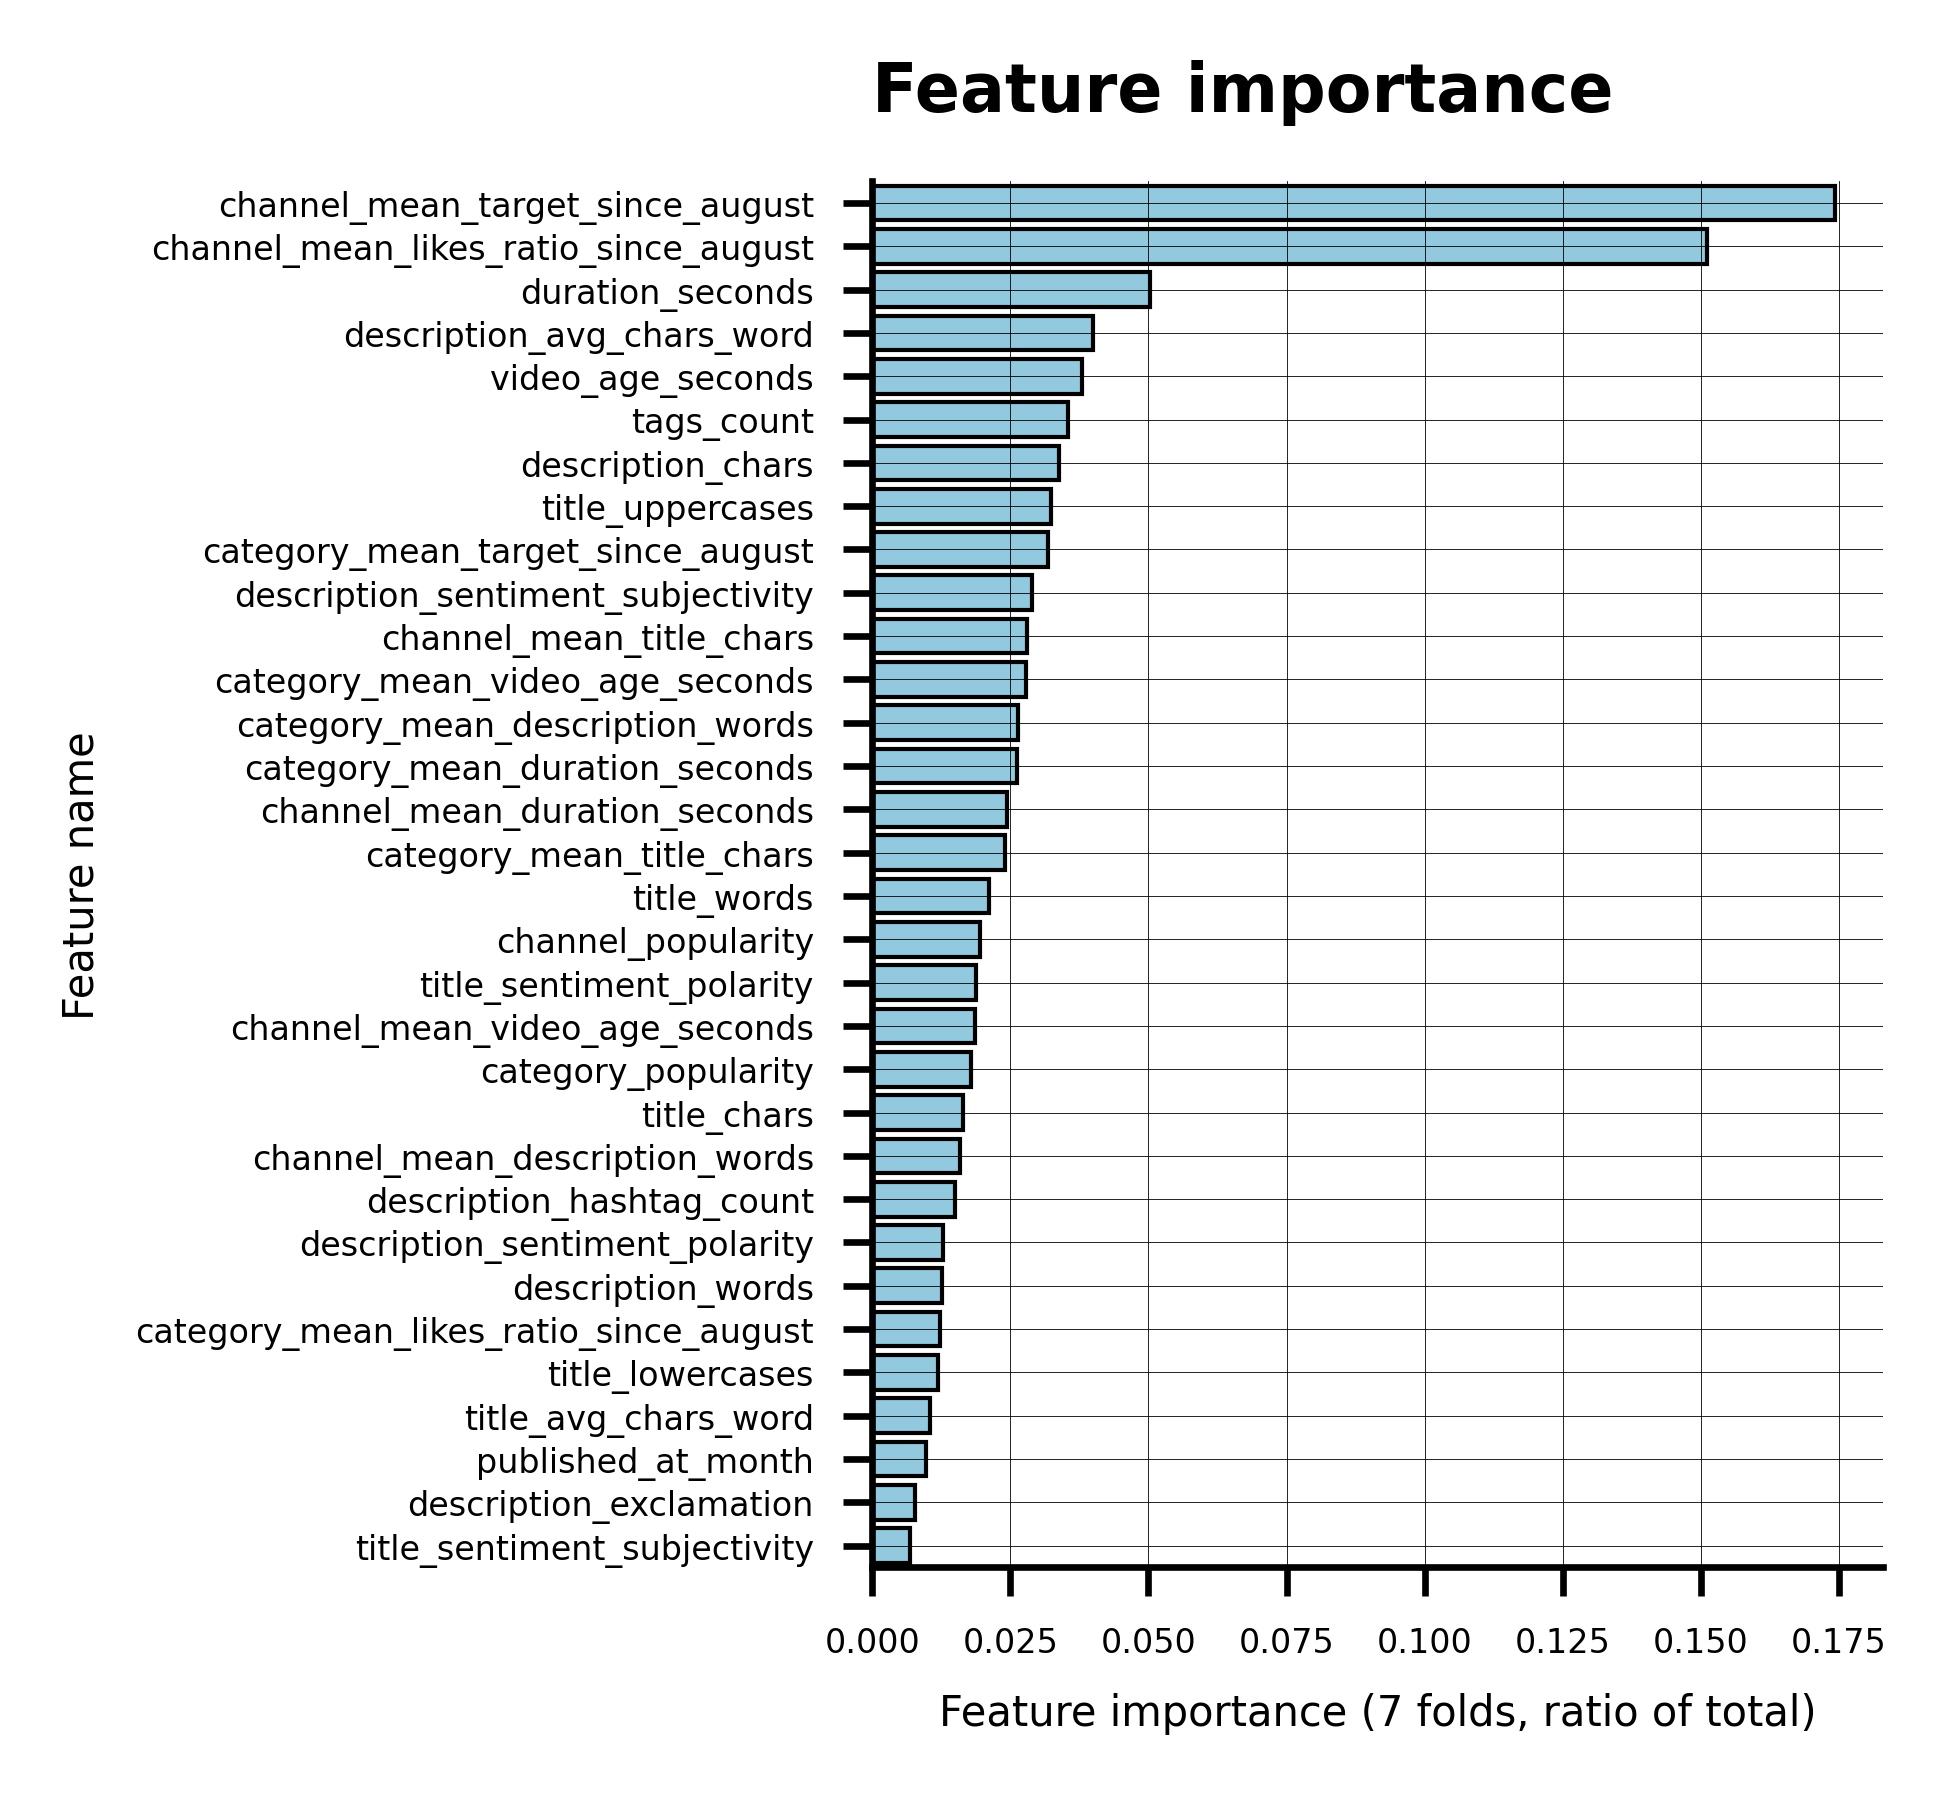

In [11]:
importances_df = pd.concat(importances, axis = 1)
importances_df['Feature'] = importance.index
importances_df['Value'] = importances_df['1_importance'] + importances_df['2_importance'] + importances_df['3_importance'] + importances_df['4_importance'] + \
                          importances_df['5_importance'] + importances_df['6_importance'] + importances_df['7_importance']
importances_df = importances_df.sort_values('Value', ascending = False)
importances_df['Value'] = importances_df['Value'] / importances_df['Value'].sum()

plt.rcParams['figure.dpi'] = 600
fig = plt.figure(figsize = (5, 3), facecolor = 'white')
gs = fig.add_gridspec(1, 2)
gs.update(wspace = 0.3, hspace = 0)
ax0 = fig.add_subplot(gs[0, 0])
ax0.set_facecolor("white")
for s in ["right", "top"]:
    ax0.spines[s].set_visible(False)

ax0.text(0, -1.8, 'Feature importance ', color = 'black', fontsize = 8, ha = 'left', va = 'bottom', weight = 'bold')
ax0_sns = sns.barplot(ax = ax0, y = importances_df['Feature'], x = importances_df['Value'], edgecolor = "black", linewidth = 0.5, color = "skyblue", orient = "h")
ax0_sns.set_ylabel("Feature name", fontsize = 5)
ax0_sns.set_xlabel("Feature importance (7 folds, ratio of total)", fontsize = 5)
ax0_sns.tick_params(labelsize = 4)
ax0.grid(True, which='both', color='black', linewidth=0.1)
plt.show()


In the constructed model, which is essentially a collection of models for each fold, we gather data about the significance of the features. We calculate the sum of the importance for each feature across all folds, and then normalize this value by dividing it by the total sum of all features. This gives us a normalized measure of how frequently a feature was used for splitting in the tree. The distribution of importance is quite wide, with some features being frequently used, while others are rarely considered.

In [12]:
sample['target'] = np.mean(np.column_stack(predictions), axis = 1)
sample = sample[['id', 'target']]
sample.to_csv("submission.csv", index = None)
sample

,id,target
0,_wNsZEqpKUA_2021-12-01,0.072171
1,2jfbXZiE6Lc_2021-12-01,0.064368
2,F1Hq8eVOMHs_2021-12-01,0.082211
3,GQXVQmcGQUY_2021-12-01,0.054703
4,n4XojTb6pfs_2021-12-01,0.076495
...,...,...
5795,hJfpCXAMYPM_2021-12-30,0.062760
5796,MbmTMEYnEzo_2021-12-30,0.059433
5797,VG7arSAYvQI_2021-12-30,0.059062
5798,SNb-g-hNYYs_2021-12-30,0.072742


Sources:
* https://www.kaggle.com/c/kaggle-pog-series-s01e01/data?select=train.parquet
* https://www.kaggle.com/robikscube/pog-on-youtube-lgbm
* https://www.kaggle.com/michau96/predict-number-of-video-views-based-on-title-only
* https://www.kaggle.com/mmellinger66/pog-youtube-lgbm-optuna
* https://www.kaggle.com/impostorengineer/basic-linear-regression
* https://www.kaggle.com/satoshiss/youtube-prediction-feature-eng/notebook
* https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html